In [1]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
#filepath_met = "C:/Users/izzfa/Documents/Data Science/Year 2/Y2Q4/DC2/Data/Metropolitan-street.parquet"
#filepath_out = "C:/Users/izzfa/Documents/Data Science/Year 2/Y2Q4/DC2/Data/Metropolitan-outcomes.parquet"
#filepath_stop = "C:/Users/izzfa/Documents/Data Science/Year 2/Y2Q4/DC2/Data/Metropolitan-stopandsearch.parquet"


filepath_met = "C:/Users/Stan/OneDrive - TU Eindhoven/Tue Dingen/DataChallenge2/DataParquet/Metropolitan-street.parquet"

# read the Parquet file into a pandas dataframe
df = pq.read_pandas(filepath_met).to_pandas()


barnet_df = df[df['LSOA name'].str.contains('Barnet')==True]
barnetBur_df = barnet_df[barnet_df['Crime type'].str.contains('Burglary')==True]
barnetBur_df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
2508,48d7fae1e76d275cfecabf17efbf6fecf769966089dcae...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.205163,51.655067,On or near Salisbury Road,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN
2509,d1d37e3e233d650abaf3eae1d6585e33f706cebe857ffc...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.203868,51.653824,On or near Union Street,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN
2532,9b09776a838d0d532429a57b320021da8bcffac6a2aa53...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.210051,51.657237,On or near Wentworth Road,E01000249,Barnet 001B,Burglary,Investigation complete; no suspect identified,NaN
2666,5c63da75bb8aa5fe30c925d6a4e58c3608bdd6fe68f33a...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.181376,51.648343,On or near Station Road,E01000251,Barnet 002D,Burglary,Investigation complete; no suspect identified,NaN
2667,6906ae484ce7bec7133bfdfa918cdcda566e04d71c465f...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.175660,51.651015,On or near Lytton Road,E01000251,Barnet 002D,Burglary,Investigation complete; no suspect identified,NaN


In [9]:
wards_csv = pd.read_csv("C:/Users/Stan/OneDrive - TU Eindhoven/Tue Dingen/DataChallenge2/DataParquet/LSOAtoWard.csv")
wards_relevant = wards_csv[['LSOA01NM', 'WD11NM']]
wards_relevant

,LSOA01NM,WD11NM
0,Barnet 020C,West Finchley
1,Barnet 019C,West Finchley
2,Barnet 020D,West Finchley
3,Barnet 020E,West Finchley
4,Barnet 036B,West Hendon
...,...,...
34373,Newport 001B,Caerleon
34374,Cardiff 019B,Cyncoed
34375,Newport 001C,Caerleon
34376,Cardiff 019C,Cyncoed


In [52]:
#Merge the main dataframe with the wards dataframe
merged_df = pd.merge(left=barnetBur_df, right=wards_relevant, left_on='LSOA name', right_on='LSOA01NM')


#Count the crimes comitted in a ward and the crimes in previous time windows in the same ward
df_crimes = merged_df[["Month", "Crime ID","WD11NM"]].copy()
df_crimes= df_crimes.groupby(["WD11NM","Month"]).count()
df_crimes["2Months"]=df_crimes['Crime ID'].shift(1, fill_value=0).add(df_crimes['Crime ID'].shift(2, fill_value=0))
df_crimes["2MonthsLag"] = df_crimes['Crime ID'].shift(3, fill_value=0).add(df_crimes['Crime ID'].shift(4, fill_value=0))
df_crimes["4Months"]=df_crimes['Crime ID'].shift(1, fill_value=0).add(df_crimes['Crime ID'].shift(2, fill_value=0)).add(df_crimes['Crime ID'].shift(3, fill_value=0)).add(df_crimes['Crime ID'].shift(4, fill_value=0))
df_crimes["4MonthsLag"]=df_crimes['Crime ID'].shift(5, fill_value=0).add(df_crimes['Crime ID'].shift(6, fill_value=0)).add(df_crimes['Crime ID'].shift(7, fill_value=0)).add(df_crimes['Crime ID'].shift(8, fill_value=0))
df_crimes['12Months'] = df_crimes['Crime ID'].rolling(window=12).sum().shift(1)

#Merge the count of crimes to the main dataframe
merged_df = pd.merge(merged_df, df_crimes, on=['Month', 'WD11NM'], how='left')
merged_df.head()

,Crime ID_x,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA01NM,WD11NM,Crime ID_y,2Months,2MonthsLag,4Months,4MonthsLag,12Months
0,48d7fae1e76d275cfecabf17efbf6fecf769966089dcae...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.205163,51.655067,On or near Salisbury Road,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN,Barnet 001A,High Barnet,7,15,21,36,59,161.0
1,d1d37e3e233d650abaf3eae1d6585e33f706cebe857ffc...,2020-05,Metropolitan Police Service,Metropolitan Police Service,-0.203868,51.653824,On or near Union Street,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN,Barnet 001A,High Barnet,7,15,21,36,59,161.0
2,6b13c905e40eccf73feec600e87a6c70e0667b10980e95...,2020-07,Metropolitan Police Service,Metropolitan Police Service,-0.207839,51.654289,On or near The Avenue,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN,Barnet 001A,High Barnet,6,17,15,32,48,137.0
3,9869e99b7803ce398498332b862347626619671258ecdb...,2021-01,Metropolitan Police Service,Metropolitan Police Service,-0.205204,51.656578,On or near Strafford Road,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN,Barnet 001A,High Barnet,10,16,28,44,38,118.0
4,83c73a8dfb5749e2f3922ff87ae87e3f0422e3cd8c88fa...,2021-01,Metropolitan Police Service,Metropolitan Police Service,-0.203575,51.655735,On or near Shopping Area,E01000248,Barnet 001A,Burglary,Investigation complete; no suspect identified,NaN,Barnet 001A,High Barnet,10,16,28,44,38,118.0


In [14]:
#Only 21 wards(should be 24) we have to check if this is different for data from a while ago
len(merged_df['WD11NM'].unique())

21

In [90]:
#Sklearn imports(and othrs)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [68]:

#Encode the wards
encoded_wards = pd.get_dummies(merged_df['WD11NM'])


#Creating the final dataframe with only relevant columns for the linear regression

df_final = encoded_wards
df_final['2Months'] = merged_df['2Months']
df_final['2MonthsLag'] = merged_df['2MonthsLag']
df_final['4Months'] = merged_df['4Months']
df_final['4MonthsLag'] = merged_df['4MonthsLag']
df_final['12Months'] = merged_df['12Months']
df_final['Crime ID_y'] = merged_df['Crime ID_y']

#Drop NaN otherwise linear regression doesnt work(Find out where the NaN is!!!)
df_final = df_final.dropna()

#Get the labels and features of the data
y = df_final['Crime ID_y']
X = df_final.drop('Crime ID_y', axis=1)


#X = merged_df[['2Months', '4Months', '6Months']]
#X = merged_df[['2Months' '2Months_lagg', '4Months', '4Months_lagg','6Months', 
#               '2Months_neighbor' '2Months_lagg_neighbor', '4Months_neighbor', 
#               '4Months_lagg_neighbor','6Months_neighbor']]

#Train/test split


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle=True) 


In [73]:
#Linera regression for the crimes in a ward

reg = LinearRegression().fit(X, y)

predictions = reg.predict(X)


score = reg.score(X, y)
score

0.43624099803164884

Text(0.5, 1.0, 'Amount of crimes per ward')

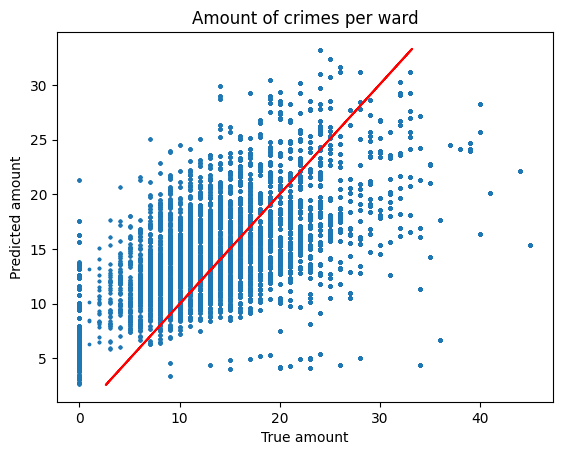

In [87]:
plt.scatter(y, predictions, s=3)

m, b = np.polyfit(predictions, y, 1)

plt.plot(predictions, m*predictions+b, c='r')

plt.xlabel('True amount')
plt.ylabel('Predicted amount')
plt.title('Amount of crimes per ward (R2=0.43624099803164884)')

Test Score: 0.9996547358729428


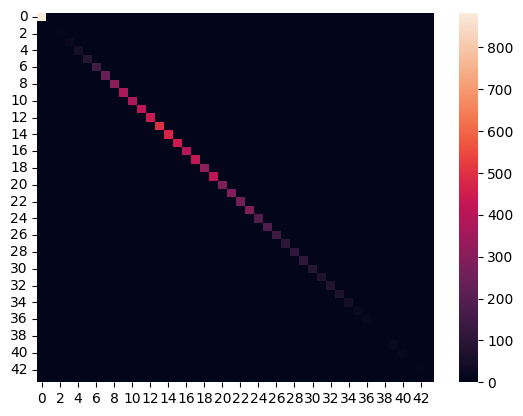

In [94]:

#Random forest classifier(for predicting in which ward crimes will take place doesnt work anymore)

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
 
#Obtain accuracy

print("Test Score:",rfc.score(X_test,y_test))

conf_mat = confusion_matrix(y_test, y_pred)
#print(conf_mat)

import seaborn
import matplotlib.pyplot as plt
seaborn.heatmap(conf_mat)
plt.show()